# Data Processing - CISP

## Notes on this notebook

In [1]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

## Imports and global variables

In [2]:
# General imports
import json
import pickle

from IPython.display import display
from lmfit import report_fit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [3]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [4]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Load and process data

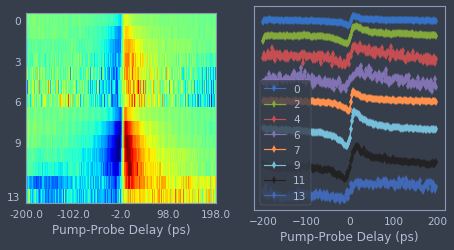

kerr_rotation  file_index  run_id  probe_delay  \
duty_cycle index_2d index_1d                                                   
0.5        0        0             -0.310331           0       0       -160.0   
                    1              0.085397           0       0       -160.0   
                    2              0.108150           0       0       -160.0   
                    3              0.032543           0       0       -160.0   
                    4              0.037324           0       0       -160.0   

                              wavelength  voltage  b_external  kerr_offset  
duty_cycle index_2d index_1d                                                
0.5        0        0             836.17      1.0      -200.0    -7.028925  
                    1             836.17      1.0      -198.0    -7.028925  
                    2             836.17      1.0      -196.0    -7.028925  
                    3             836.17      1.0      -194.0    -7.028925  
                    4             836.17      1.0      -192.0    -7.028925

In [133]:
# REQUIRED: columns & labels used to plot data.
# may be present in the raw data or defined somewhere
# below. If column is renamed below, this variable
# will also be updated to reflect the new name.
scan_coordinate_column = "Magnetic Field (T)"
measured_value_column = "kerr_rotation"
scan_coordinate_label = "Pump-Probe Delay (ps)"

# REQUIRED: output filenames
output_dataframe_filename = "processed_dataframe.csv"
output_metadata_list_filename = "processed_metadata_list.json"
output_image_filename = "processed_dataframe_plot.png"

# REQUIRED: data directory
parent_dir = ('.')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 0
column_names_row = 1  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [
    (       "CISP", "Experiment Type", "CISP"       ),
    ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
    ( "Field_Scan", "Experiment Type", "Field_Scan" ),
    ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
    ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
    ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = []
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
#         ("FIELD", "Date_and_Scan_2D_Index"),  # NOT so in CISP data
    ("VLMF", "VLMF"),  # CISP-specific?
    ("Onoff-", "Duty Cycle"),  # CISP-specific?
    ("phi-", "Electric Field Angle"),  # CISP-specific?
    ("DLAY", "Date_and_Scan_2D_Index"),
    ("STPR", "Date_and_Scan_2D_Index"),
    ("T", "Magnetic Field (T)"),
    ("K", "Set Temperature (K)"),
    ("nm", "Wavelength (nm)"),
    ("ps", "Delay Time (ps)"),
    ("V", "Voltage (V)"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def derive_2d_index_from_voltage(metadata_dict):  # dataset quirk
    if 'Voltage (V)' in metadata_dict.keys():
        integer_voltage = int(metadata_dict['Voltage (V)'])
        metadata_dict['Scan_2D_Index'] = integer_voltage - 1
#     # not needed for field scan: magnetic field is col, not metadata
#     def consolidate_aliases_for_bfield(metadata_dict):
#         if 'Magnetic Field (T)' in metadata_dict.keys():
#             metadata_dict['Magnetic Field (mT)'] = \
#                 1000.0 * metadata_dict['Magnetic Field (T)']
#             del metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [derive_2d_index_from_voltage]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
    lambda metadata_dict: \
        "alignment" not in metadata_dict.get("Filepath"),
#     lambda metadata_dict: \
#         metadata_dict.get("# repeats", 1) <= 2,
    lambda metadata_dict: \
        "Scan_2D_Index" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (              'Run ID', 'run_id'),
    (          'Duty Cycle', 'duty_cycle'),  # used like run ID
    (       'Scan_2D_Index', 'index_2d'),
    (     'Delay Time (ps)', 'probe_delay'),
    ('Mirror Position (um)', 'mirror_pos'),
    ( 'Magnetic Field (mT)', 'b_external'),
    (     'Wavelength (nm)', 'wavelength'),
    (         'Voltage (V)', 'voltage'),
]

# OPTIONAL: dictionary describing column names to rewrite,
# whether derived from metadata or not. By default,
# includes the above dictionary's aliases. Also,
# update the column names above
# Key:value pairs should be of form 'old name':'new name'
column_renaming_dict = \
    {key:val for key, val in metadata_tag_to_column_list}
column_renaming_dict.update({
    'Lock-In Average (V)': 'kerr_rotation',
    'Magnetic Field (mT)': 'b_external',
     'Magnetic Field (T)': 'b_external',  # for renaming m_v_c
})
if scan_coordinate_column in column_renaming_dict:
    scan_coordinate_column = \
        column_renaming_dict[scan_coordinate_column]
if measured_value_column in column_renaming_dict:
    measured_value_column = \
        column_renaming_dict[measured_value_column]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['duty_cycle', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def rescale_magnetic_field(df):
    if 'Magnetic Field (T)' in list(df):
        df['Magnetic Field (mT)'] = 1000.0 * df['Magnetic Field (T)']
        del df['Magnetic Field (T)']
def edit_dataframe_colnames(df):  # should usually be last
    filtered_renaming_dict = \
        {key: val for (key, val) in column_renaming_dict.items()
         if key in list(df)}
    df.rename(columns=filtered_renaming_dict, inplace=True)
def subtract_cisp_y_offset(df):
    def extract_kerr_offset(df):
        kerr_rot = df['kerr_rotation']
        kerr_avg = np.mean(kerr_rot.values)
        df['kerr_offset'] = -kerr_avg * np.ones_like(kerr_rot)
        df['kerr_rotation'] -= kerr_avg
        return df
    df['kerr_offset'] = 0
    dfg = df.groupby(level=[-3, -2])
    updated_df = dfg.apply(extract_kerr_offset)
    for colname in ['kerr_rotation', 'kerr_offset']:
        df[colname] = updated_df[colname]  # apply updates
dataframe_processing_fcns = [
    set_dataframe_indices,
    rescale_magnetic_field,
    edit_dataframe_colnames,
    subtract_cisp_y_offset,
]

file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# Save processed dataframe & metadata to file
with open(output_dataframe_filename, 'w') as f:
    full_dataframe.to_csv(f, sep='\t')
with open(output_metadata_list_filename, 'w') as f:
    json.dump(file_metadata_list, f)

# plot newly created dataframe and show the first few rows
figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
num_waterfall_plots = [0, 2, 4, 6, 7, 9, 11, 13]
data_column = measured_value_column
x_values_column = scan_coordinate_column
y_values_column = None
xlabel = scan_coordinate_label
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.savefig(output_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()
display(full_dataframe.head(5))

In [134]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

Sample Orientation: [1-10]Horiz
Sample ID: RMBE1130-K
Delay Time (ps): -160.0
Electric Field Angle: 45.0
Run ID: 0
Scan_2D_Index: 0
Voltage (V): 1.0
File Last Modified: Sun Aug 20 00:27:14 2017
Wavelength (nm): 836.17
Filepath: .\VLMF02 Onoff-0.5\FIELD01 VLMF02 RMBE1130-K_30K_-160ps_836.17nm_[1-10]Horiz_Onoff-0.5 1.00V phi-45.dat
VLMF: 2.0
Set Temperature (K): 30.0
Duty Cycle: 0.5


kerr_rotation  file_index  run_id  probe_delay  \
duty_cycle index_2d index_1d                                                   
0.5        0        0             -0.310331           0       0       -160.0   
                    1              0.085397           0       0       -160.0   
                    2              0.108150           0       0       -160.0   
                    3              0.032543           0       0       -160.0   
                    4              0.037324           0       0       -160.0   

                              wavelength  voltage  b_external  kerr_offset  
duty_cycle index_2d index_1d                                                
0.5        0        0             836.17      1.0      -200.0    -7.028925  
                    1             836.17      1.0      -198.0    -7.028925  
                    2             836.17      1.0      -196.0    -7.028925  
                    3             836.17      1.0      -194.0    -7.028925  
                    4             836.17      1.0      -192.0    -7.028925

In [135]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df.head()

## Dataset fit model and residuals

In [136]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from eda.analysis.fit_tools import create_residuals_fcn

def CISP_lorentzian_fcn(b_external, amplitude, gfactor,
                        delay_time, b_zero_offset,
                        slope, offset):
    offset_b_ext = b_external - b_zero_offset
    x = GFACTORCONSTANT * gfactor * offset_b_ext * delay_time
    output = (amplitude * x / (1 + np.power(x, 2))) + offset
    return output

CISP_lorentzian_residuals = \
    create_residuals_fcn(CISP_lorentzian_fcn, ['b_external'])

## Dataset fit parameter setup and constraints

In [137]:
from lmfit import Parameters

params_guesses = [('amplitude',           {'value' : 1.0,
                                           'min'   : -1e3,
                                           'max'   : +1e3,
                                           'vary'  : True}),
                  ('gfactor',             {'value' : 40.0,
#                                            'min'   : 0.3,
#                                            'max'   : 0.5,
                                           'vary'  : True}),
                  ('delay_time',          {'value' : -160.0,
                                           'vary'  : False}),
                  ('b_zero_offset',       {'value' : 0.0,
                                           'vary'  : False}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1e2,
                                           'max'   : +1e2,
                                           'vary'  : False}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1e2,
                                           'max'   : +1e2,
                                           'vary'  : True}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## Fit all datasets (1D)

file_index  run_id  probe_delay  wavelength  voltage  \
duty_cycle index_2d                                                         
0.5        0.0              0.0     0.0       -160.0      836.17      1.0   
           1.0              1.0     0.0       -160.0      836.17      2.0   
           2.0              2.0     0.0       -160.0      836.17      3.0   
           3.0              3.0     0.0       -160.0      836.17      4.0   
           4.0              4.0     0.0       -160.0      836.17      5.0   

                     kerr_offset  amplitude  amplitude_error    gfactor  \
duty_cycle index_2d                                                       
0.5        0.0         -7.028925  -1.980158         0.091736  78.242087   
           1.0        -13.152661  -3.195547         0.129807  65.510399   
           2.0        -19.617127  -3.760589         0.114484  51.133220   
           3.0        -29.261423  -3.749749         0.206049  47.586387   
           4.0        -39.193410  -3.566288         0.347656  47.916187   

                     gfactor_error  delay_time  b_zero_offset  slope  \
duty_cycle index_2d                                                    
0.5        0.0            5.225327      -160.0            0.0    0.0   
           1.0            3.851304      -160.0            0.0    0.0   
           2.0            2.268905      -160.0            0.0    0.0   
           3.0            3.820547      -160.0            0.0    0.0   
           4.0            6.821993      -160.0            0.0    0.0   

                       offset  offset_error  result_index     chisqr    redchi  
duty_cycle index_2d                                                             
0.5        0.0       0.000282      0.009680             0   3.715771  0.018862  
           1.0       0.000544      0.015028             1   8.886098  0.045107  
           2.0       0.000819      0.014995             2   8.854019  0.044944  
           3.0       0.000878      0.027980             3  30.819850  0.156446  
           4.0       0.000829      0.047063             4  87.164808  0.442461

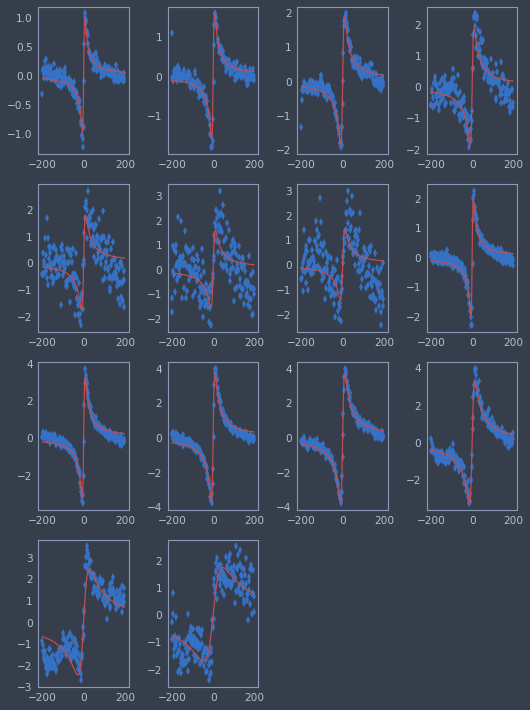

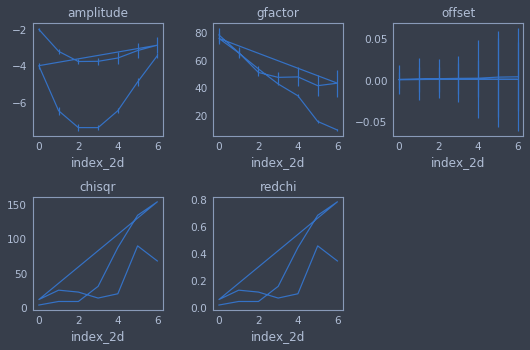

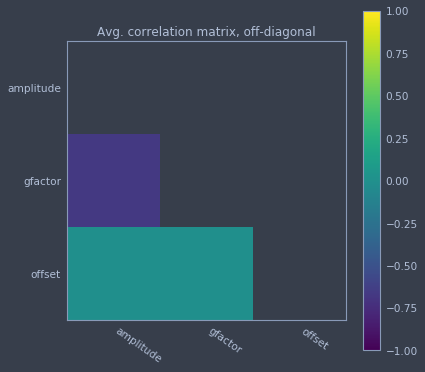

In [138]:
from eda.analysis.dataframe_processing \
    import df_minimize_fcn_on_datasets

df = full_dataframe
residuals_fcn = CISP_lorentzian_residuals
fit_params = fit_params
independent_vars_columns = ["b_external"]
measured_data_column = measured_value_column
column_aggregation_dict = {}  # needed to keep cols w/ non-const values
keep_const_columns = True

output_fit_results_dataframe_filename = "fit_results_dataframe.csv"
output_fit_minimize_results_filename = "fit_minimize_results.pickle"
output_fit_vs_data_image_filename = "fit_results_fit_vs_data.png"
output_fit_params_image_filename = "fit_results_fit_params.png"
output_fit_covariances_image_filename = "fit_results_covariances.png"

# Fit!
minimize_results, results_df = \
    df_minimize_fcn_on_datasets(
        df, residuals_fcn, fit_params,
        independent_vars_columns,
        measured_data_column,
        column_aggregation_dict=column_aggregation_dict,  # keywords only!
#         method='nelder',
        keep_const_columns=keep_const_columns,
    )

# add minimizer result attributes to results_df
attributes_to_add = ['chisqr', 'redchi']
for attribute in attributes_to_add:
    attribute_list = []
    for result in minimize_results:
        attribute_list.append(getattr(result, attribute))
    results_df[attribute] = attribute_list

# Display fit params dataframe & save to file
with open(output_fit_results_dataframe_filename, 'w') as f:
    results_df.to_csv(f, sep='\t')
with open(output_fit_minimize_results_filename, 'wb') as f:
    pickle.dump(minimize_results, f)
display(results_df.head(5))

# plot fits
ncols = 4
nplots = len(minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = minimize_results[result_index]
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()
plt.savefig(output_fit_vs_data_image_filename,
            bbox_inches='tight',
            transparent=False)

# plot params
params_to_plot_list = result.var_names + attributes_to_add
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(results_df):
        ax.errorbar(x=results_df.index.get_level_values(-1),
                    y=results_df[param],
                    yerr=results_df[param + '_error'])
    else:
        ax.plot(results_df.index.get_level_values(-1),
                results_df[param].values)
    plt.xlabel(results_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)
plt.savefig(output_fit_params_image_filename,
            bbox_inches='tight',
            transparent=False)

# Plot the avg. covariance matrix
corr_mats = []
for result in minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names
                         if param.stderr != 0])
    corr = np.dot(np.dot(oostd, result.covar), oostd).astype(np.float)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(avgcorr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.savefig(output_fit_covariances_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()


----------------------------------------


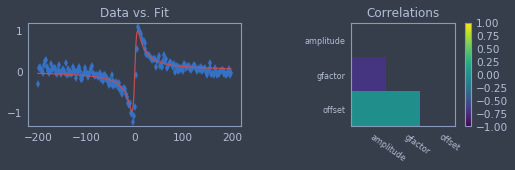

FIT #1
duty_cycle: 0.5
index_2d: 0.0
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 200
    # variables        = 3
    chi-square         = 3.716
    reduced chi-square = 0.019
    Akaike info crit   = -791.146
    Bayesian info crit = -781.251
[[Variables]]
    amplitude:      -1.98015751 +/- 0.091736 (4.63%) (init= 1)
    gfactor:         78.2420871 +/- 5.225327 (6.68%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00028231 +/- 0.009679 (3428.76%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.694 


None

----------------------------------------


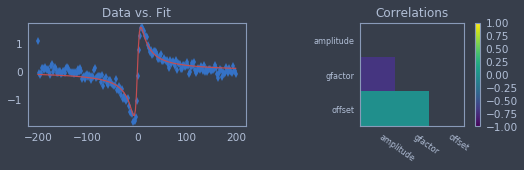

FIT #2
duty_cycle: 0.5
index_2d: 1.0
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 200
    # variables        = 3
    chi-square         = 8.886
    reduced chi-square = 0.045
    Akaike info crit   = -616.766
    Bayesian info crit = -606.871
[[Variables]]
    amplitude:      -3.19554685 +/- 0.129806 (4.06%) (init= 1)
    gfactor:         65.5103994 +/- 3.851304 (5.88%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00054393 +/- 0.015027 (2762.78%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.691 


None

----------------------------------------


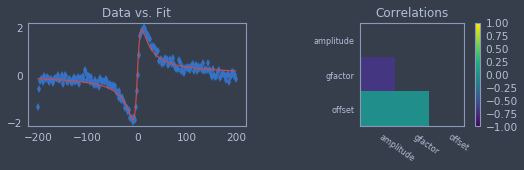

FIT #3
duty_cycle: 0.5
index_2d: 2.0
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 200
    # variables        = 3
    chi-square         = 8.854
    reduced chi-square = 0.045
    Akaike info crit   = -617.489
    Bayesian info crit = -607.594
[[Variables]]
    amplitude:      -3.76058920 +/- 0.114483 (3.04%) (init= 1)
    gfactor:         51.1332198 +/- 2.268904 (4.44%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00081949 +/- 0.014995 (1829.81%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.686 


None

----------------------------------------


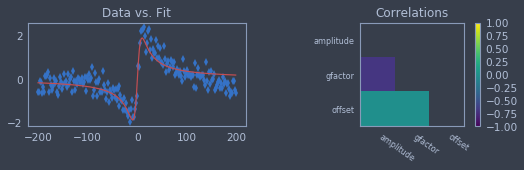

FIT #4
duty_cycle: 0.5
index_2d: 3.0
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 200
    # variables        = 3
    chi-square         = 30.820
    reduced chi-square = 0.156
    Akaike info crit   = -368.032
    Bayesian info crit = -358.137
[[Variables]]
    amplitude:      -3.74974949 +/- 0.206048 (5.50%) (init= 1)
    gfactor:         47.5863868 +/- 3.820547 (8.03%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00087777 +/- 0.027979 (3187.61%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.684 


None

----------------------------------------


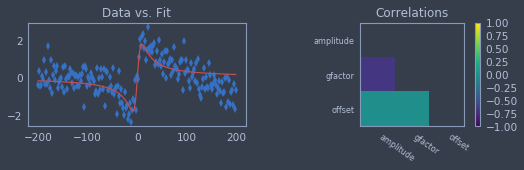

FIT #5
duty_cycle: 0.5
index_2d: 4.0
[[Fit Statistics]]
    # function evals   = 44
    # data points      = 200
    # variables        = 3
    chi-square         = 87.165
    reduced chi-square = 0.442
    Akaike info crit   = -160.103
    Bayesian info crit = -150.208
[[Variables]]
    amplitude:      -3.56628796 +/- 0.347656 (9.75%) (init= 1)
    gfactor:         47.9161869 +/- 6.821992 (14.24%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00082910 +/- 0.047062 (5676.33%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.684 


None

----------------------------------------


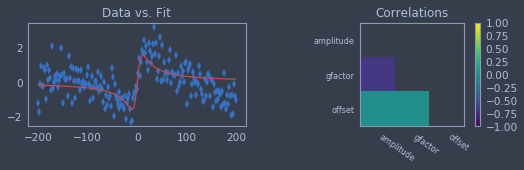

FIT #6
duty_cycle: 0.5
index_2d: 5.0
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 200
    # variables        = 3
    chi-square         = 133.939
    reduced chi-square = 0.680
    Akaike info crit   = -74.187
    Bayesian info crit = -64.292
[[Variables]]
    amplitude:      -3.15405331 +/- 0.401607 (12.73%) (init= 1)
    gfactor:         41.5704730 +/- 7.776393 (18.71%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00084459 +/- 0.058257 (6897.71%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.681 


None

----------------------------------------


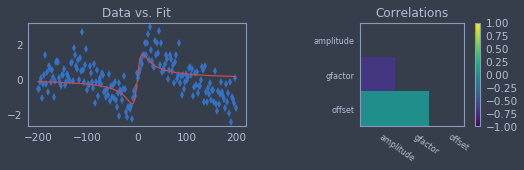

FIT #7
duty_cycle: 0.5
index_2d: 6.0
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 200
    # variables        = 3
    chi-square         = 153.561
    reduced chi-square = 0.779
    Akaike info crit   = -46.844
    Bayesian info crit = -36.949
[[Variables]]
    amplitude:      -2.85635909 +/- 0.439249 (15.38%) (init= 1)
    gfactor:         43.3739664 +/- 9.782416 (22.55%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00073325 +/- 0.062394 (8509.39%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.682 


None

----------------------------------------


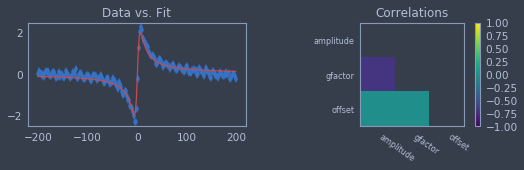

FIT #8
duty_cycle: 1.0
index_2d: 0.0
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 200
    # variables        = 3
    chi-square         = 11.677
    reduced chi-square = 0.059
    Akaike info crit   = -562.146
    Bayesian info crit = -552.251
[[Variables]]
    amplitude:      -3.99079454 +/- 0.160026 (4.01%) (init= 1)
    gfactor:         75.7782251 +/- 4.382883 (5.78%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00058743 +/- 0.017160 (2921.26%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.693 


None

----------------------------------------


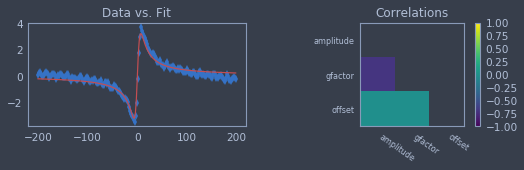

FIT #9
duty_cycle: 1.0
index_2d: 1.0
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 200
    # variables        = 3
    chi-square         = 25.289
    reduced chi-square = 0.128
    Akaike info crit   = -407.593
    Bayesian info crit = -397.698
[[Variables]]
    amplitude:      -6.48672650 +/- 0.218593 (3.37%) (init= 1)
    gfactor:         65.2625664 +/- 3.183601 (4.88%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00110833 +/- 0.025313 (2283.96%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.691 


None

----------------------------------------


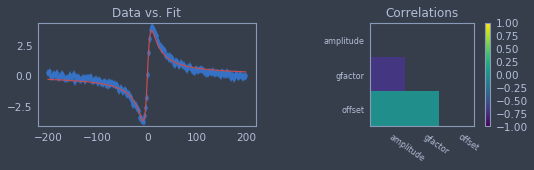

FIT #10
duty_cycle: 1.0
index_2d: 2.0
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 200
    # variables        = 3
    chi-square         = 22.522
    reduced chi-square = 0.114
    Akaike info crit   = -430.762
    Bayesian info crit = -420.867
[[Variables]]
    amplitude:      -7.42226697 +/- 0.187082 (2.52%) (init= 1)
    gfactor:         53.6870011 +/- 1.969211 (3.67%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00154075 +/- 0.023918 (1552.37%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.687 


None

----------------------------------------


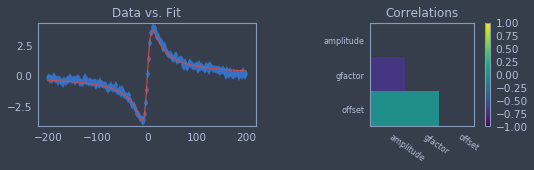

FIT #11
duty_cycle: 1.0
index_2d: 3.0
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 200
    # variables        = 3
    chi-square         = 13.841
    reduced chi-square = 0.070
    Akaike info crit   = -528.130
    Bayesian info crit = -518.235
[[Variables]]
    amplitude:      -7.42366865 +/- 0.130979 (1.76%) (init= 1)
    gfactor:         42.8174360 +/- 1.108141 (2.59%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00193034 +/- 0.018734 (970.54%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.682 


None

----------------------------------------


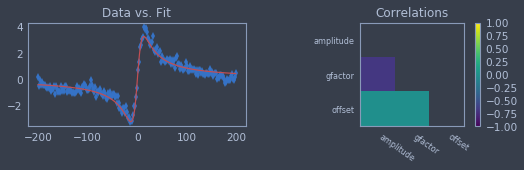

FIT #12
duty_cycle: 1.0
index_2d: 4.0
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 200
    # variables        = 3
    chi-square         = 20.088
    reduced chi-square = 0.102
    Akaike info crit   = -453.638
    Bayesian info crit = -443.743
[[Variables]]
    amplitude:      -6.48404625 +/- 0.141133 (2.18%) (init= 1)
    gfactor:         34.2560158 +/- 1.104886 (3.23%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00210418 +/- 0.022584 (1073.31%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.674 


None

----------------------------------------


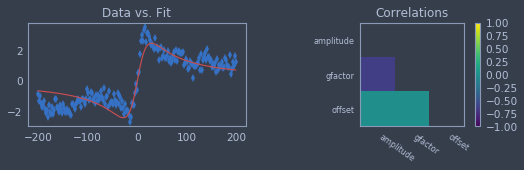

FIT #13
duty_cycle: 1.0
index_2d: 5.0
[[Fit Statistics]]
    # function evals   = 65
    # data points      = 200
    # variables        = 3
    chi-square         = 89.570
    reduced chi-square = 0.455
    Akaike info crit   = -154.659
    Bayesian info crit = -144.764
[[Variables]]
    amplitude:      -4.89523260 +/- 0.201920 (4.12%) (init= 1)
    gfactor:         15.7262322 +/- 1.029329 (6.55%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00340641 +/- 0.047683 (1399.83%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.626 


None

----------------------------------------


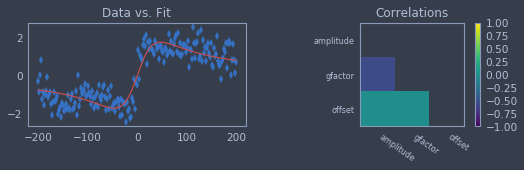

FIT #14
duty_cycle: 1.0
index_2d: 6.0
[[Fit Statistics]]
    # function evals   = 57
    # data points      = 200
    # variables        = 3
    chi-square         = 67.653
    reduced chi-square = 0.343
    Akaike info crit   = -210.786
    Bayesian info crit = -200.891
[[Variables]]
    amplitude:      -3.43510149 +/- 0.136478 (3.97%) (init= 1)
    gfactor:         9.49050072 +/- 0.662392 (6.98%) (init= 40)
    delay_time:     -160 (fixed)
    b_zero_offset:   0 (fixed)
    slope:           0 (fixed)
    offset:          0.00382886 +/- 0.041442 (1082.38%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, gfactor)        = -0.546 


None

In [139]:
# DETAILED FIT REPORTS
for result_index, result in enumerate(minimize_results):
    print('----------------------------------------')
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,
                                   figsize=(FIG_SIZE_MULT * 3,
                                            FIG_SIZE_MULT * 1))
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax1.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax1.plot(xvals, fit_yvals, 'r')
    ax1.set_title('Data vs. Fit')
    img = ax2.imshow(corr_mats[result_index], vmin=-1, vmax=1)
    fig.colorbar(img, ax=ax2)
    plt.xticks(np.arange(result.nvarys), result.var_names,
               rotation=-35, ha='left', fontsize=8)
    plt.yticks(np.arange(result.nvarys), result.var_names, fontsize=8)
    ax2.set_title('Correlations')
    plt.tight_layout()
    plt.show()
    print('FIT #{}'.format(result_index + 1))
    for col, val in zip(results_df.index.names,
                        results_df.index[result_index]):
        print('{}: {}'.format(col, val))
    display(report_fit(result))